<a href="https://colab.research.google.com/github/ebagdasa/federated/blob/master/analytics/location_heatmaps/dp_location_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Location Heatmaps under Distributed Differential Privacy with Secure Aggregation

This code shows examples of the proposed algorithm. We use publicly available [map](https://www.nytimes.com/2018/12/14/reader-center/phone-data-location-investigation.html) from the NYTimes article and population density from [Facebook Humanitarian Data Project](https://data.humdata.org/organization/facebook).


To cite our work use:




In [1]:
!git clone https://github.com/ebagdasa/federated.git

Cloning into 'federated'...
remote: Enumerating objects: 2786, done.
remote: Counting objects: 100% (432/432), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 2786 (delta 331), reused 338 (delta 286), pack-reused 2354
Receiving objects: 100% (2786/2786), 2.57 MiB | 6.77 MiB/s, done.
Resolving deltas: 100% (1940/1940), done.


In [3]:
!pip install torch
!pip install matplotlib
!pip install tqdm
!pip install pygtrie

  Created wheel for pygtrie: filename=pygtrie-2.4.2-cp37-none-any.whl size=19063 sha256=90bc2ce9ec6a8dfbcc9f1b0d1cf478fdef9ade164f9f90f3882e5ef6e1923952
  Stored in directory: /root/.cache/pip/wheels/db/57/91/73782136379fe419036c5ec0e4070d8b3a35f2a36bd6a94ed8
Successfully built pygtrie


In [4]:
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm

In [5]:
import sys
sys.path.insert(1, "federated/analytics/location_heatmaps")

In [6]:
from run_experiment import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import geo_utils
import metrics
import mechanisms

In [7]:
# !wget https://static01.nyt.com/images/2018/12/14/business/10location-insider/10location-promo-superJumbo-v2.jpg
!wget https://www.cs.cornell.edu/~eugene/assets/images/location_heatmap.jpg

--2021-07-03 23:42:30--  https://www.cs.cornell.edu/~eugene/assets/images/location_heatmap.jpg
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924651 (4.7M) [image/jpeg]
Saving to: ‘location_heatmap.jpg’

location_heatmap.jp 100%[===================>]   4.70M  7.75MB/s    in 0.6s    

2021-07-03 23:42:31 (7.75 MB/s) - ‘location_heatmap.jpg’ saved [4924651/4924651]



In [8]:
true_image, dataset = get_data('location_heatmap.jpg')

100%|██████████| 1024/1024 [00:15<00:00, 67.67it/s]


In [16]:
print(f'Total users on the map: {true_image.sum():,}.')

Total users on the map: 54,599,988.


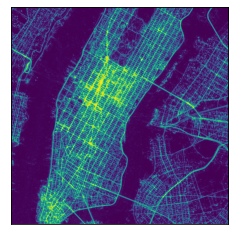

In [9]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(true_image)

## Algorithm design

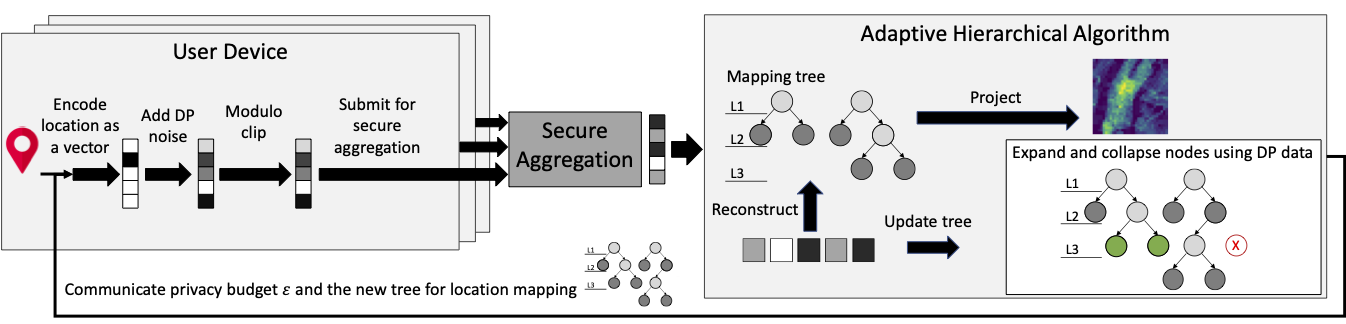

Briefly, our algorithm iteratively explores regions collapsing and expanding depending on the provided dynamic thresholds. It can also balance the privacy budget depending on the result obtained from the previous round of the algorithm. 

To achieve differential privacy under secure aggregation we use distributed geometric noise (see Section 4). We set SecAgg shard size to 10,000.

### No DP

We begin with a sample run, with 10k

positivity: False
Total of 100.0 SecAgg rounds per level


 19%|█▊        | 1874/10000 [00:00<00:00, 9634.65it/s] 

Level: 0. Eps: None. Threshold: 10.00. Remaining: 0.00


 21%|██        | 2113/10000 [00:00<00:00, 11015.08it/s]

Level: 0. MSE: 9.68e-11, without sampling error: 1.35e-12.
Level: 1. Eps: None. Threshold: 10.00. Remaining: 0.00


 17%|█▋        | 1653/10000 [00:00<00:01, 8338.60it/s]

Level: 1. MSE: 9.65e-11, without sampling error: 1.09e-12.
Level: 2. Eps: None. Threshold: 10.00. Remaining: 0.00


  8%|▊         | 795/10000 [00:00<00:01, 7945.88it/s]

Level: 2. MSE: 9.63e-11, without sampling error: 8.82e-13.
Level: 3. Eps: None. Threshold: 10.00. Remaining: 0.00


 12%|█▏        | 1192/10000 [00:00<00:00, 11913.88it/s]

Level: 3. MSE: 9.61e-11, without sampling error: 7.81e-13.
Level: 4. Eps: None. Threshold: 10.00. Remaining: 0.00


 11%|█         | 1069/10000 [00:00<00:00, 10688.91it/s]

Level: 4. MSE: 9.60e-11, without sampling error: 7.75e-13.
Level: 5. Eps: None. Threshold: 10.00. Remaining: 0.00


 11%|█         | 1102/10000 [00:00<00:00, 11014.63it/s]

Level: 5. MSE: 9.59e-11, without sampling error: 9.38e-13.
Level: 6. Eps: None. Threshold: 10.00. Remaining: 0.00


Level: 6. MSE: 9.59e-11, without sampling error: 9.56e-13.
Finished expanding, no new results.
Total epsilon-users: 0.00 with 0.00 eps per person. 


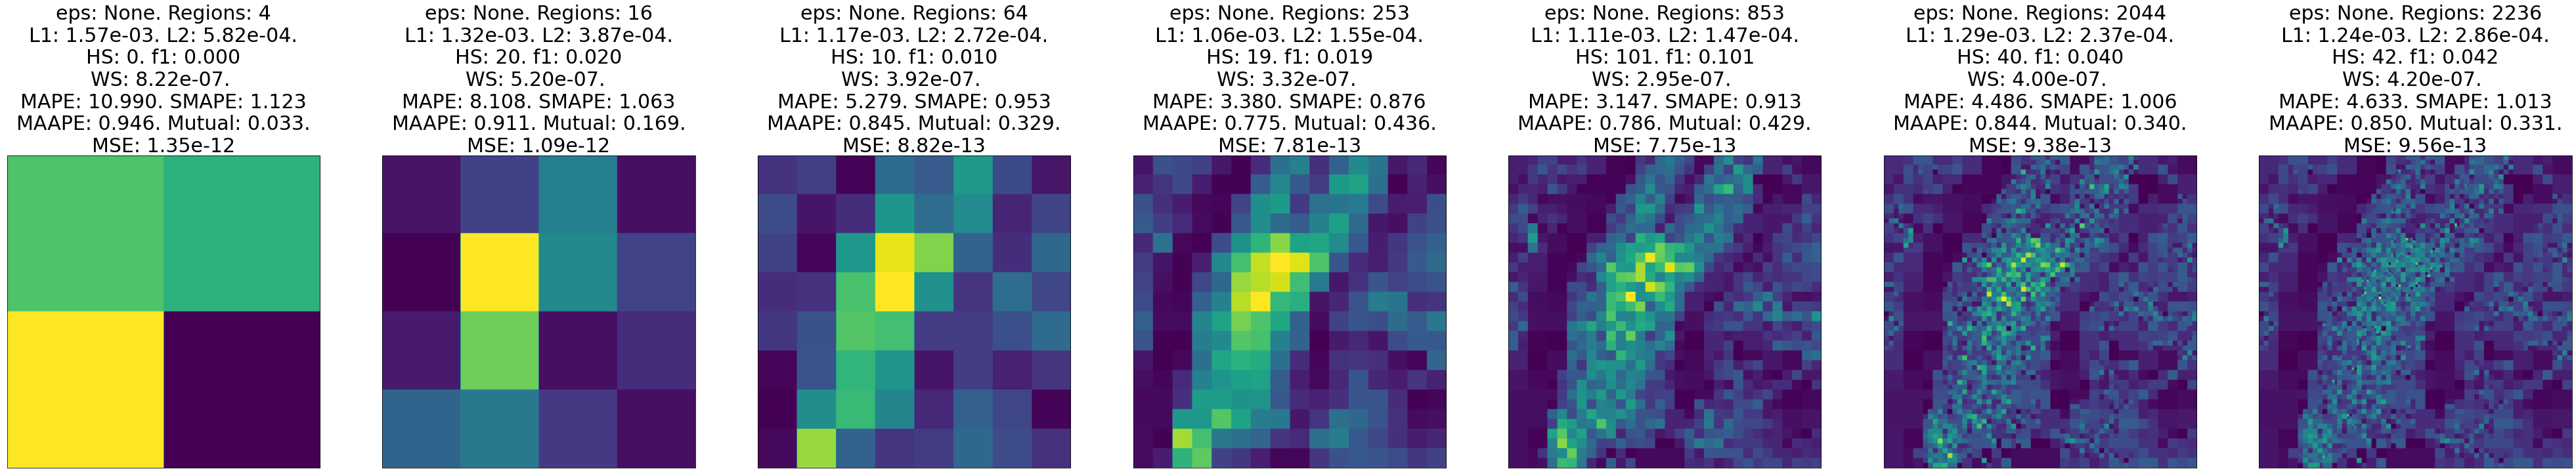

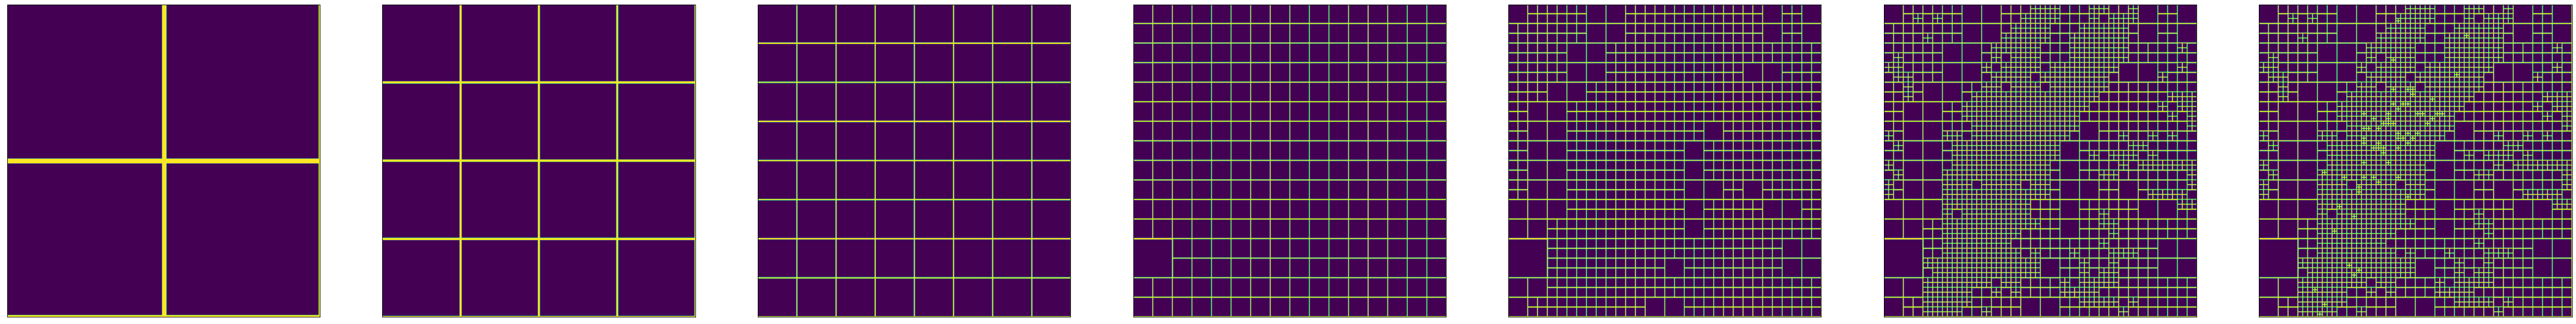

In [13]:
users = 10000
secagg_size = 100
c = secagg_size / users
res10_nodp = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: None,
                   threshold=10,
                   top_k=TOPK,
                   partial=1,
                   max_levels=7,
                   total_size=TOTAL_SIZE,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)

## Algorithm 2

For each level of the algorithm we use method `get_eps_from_two_std()` that computes budget using Equation 8, i.e. it assures that the produced noise is proportional to an approximate ratio of users to a number of sub-regions.

```python
mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions)
```

10k users (no dropout)

positivity: False
Total of 1.0 SecAgg rounds per level


  0%|          | 0/10000 [00:00<?, ?it/s]

Level: 0. Eps: 0.01131364816007492. Threshold: 10.00. Remaining: 1.00


  9%|▉         | 910/10000 [00:00<00:00, 9099.40it/s]

Level: 0. MSE: 9.64e-11, without sampling error: 1.35e-12.
Level: 1. Eps: 0.04525097313957988. Threshold: 10.00. Remaining: 0.99


  7%|▋         | 701/10000 [00:00<00:01, 6940.85it/s]

Level: 1. MSE: 9.61e-11, without sampling error: 1.09e-12.
Level: 2. Eps: 0.18077309093243188. Threshold: 10.00. Remaining: 0.94


  4%|▍         | 401/10000 [00:00<00:02, 3593.91it/s]

Level: 2. MSE: 9.59e-11, without sampling error: 8.86e-13.
Last round. Spending remaining epsilon budget: 7626.622877679133
Level: 3. Eps: 0.7626622877679133. Threshold: 10.00. Remaining: 0.76


Level: 3. MSE: 9.58e-11, without sampling error: 7.86e-13.
Total epsilon-users: 10000.00 with 1.00 eps per person. 


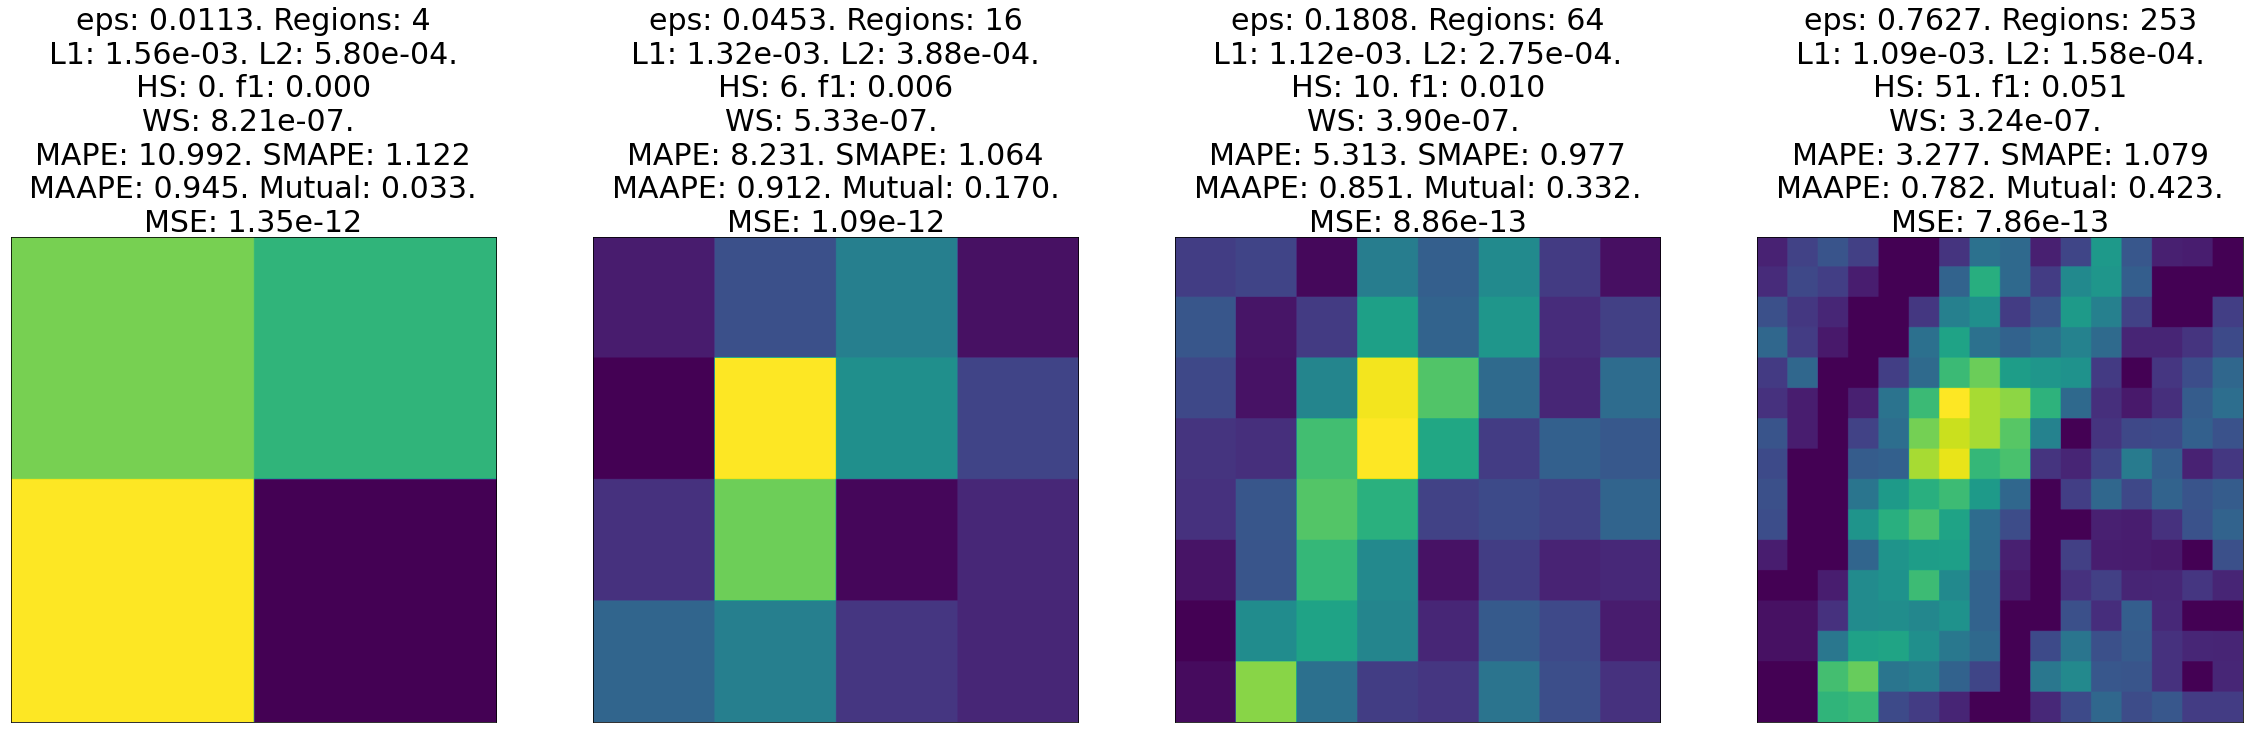

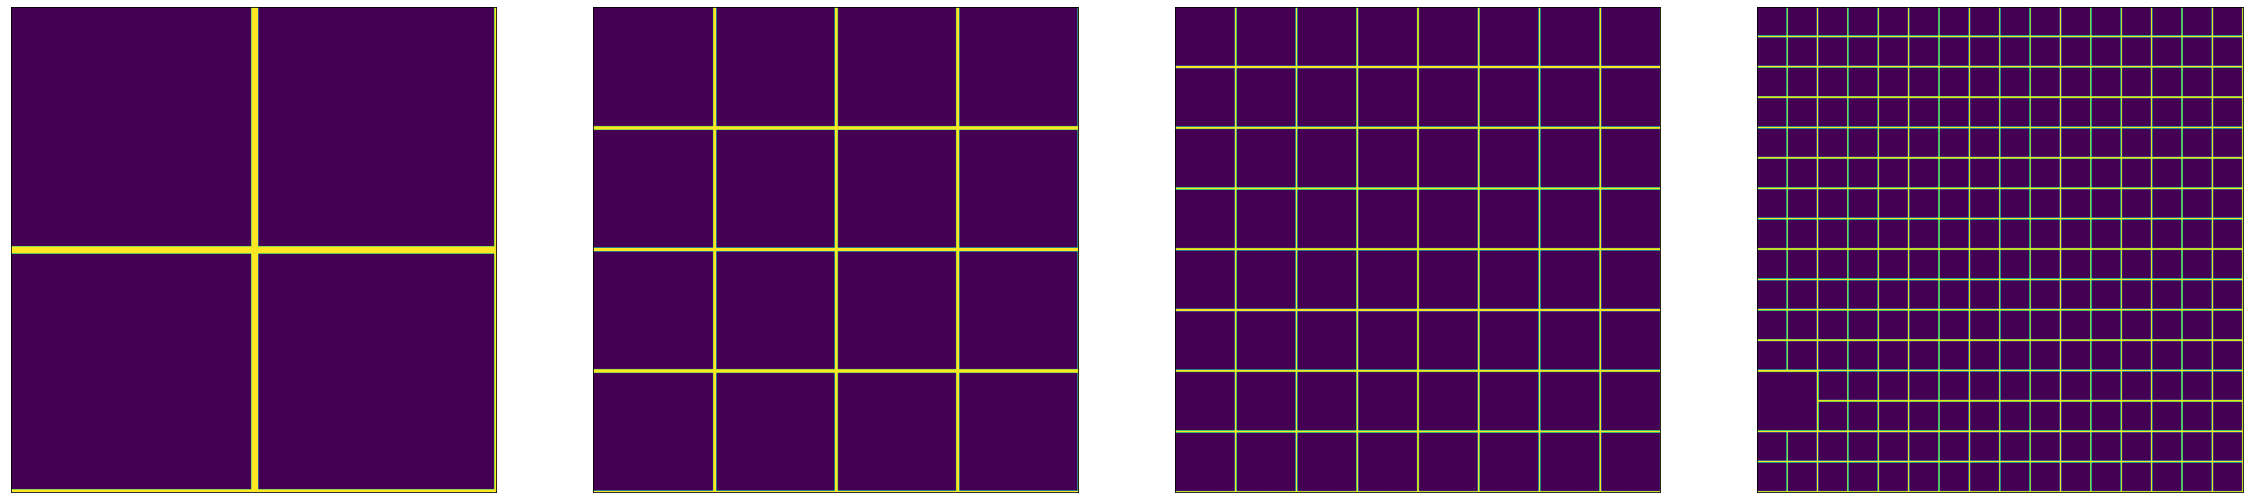

In [14]:
users = 10000
secagg_size = 10000
c = 1/10
res10k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)


### 100K users with 10% dropout and distributed DP

positivity: False
Total of 10.0 SecAgg rounds per level


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. Eps: 0.003577706855891111. Threshold: 10.00. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. MSE: 1.09e-11, without sampling error: 1.35e-12.
Level: 1. Eps: 0.014310712939686405. Threshold: 10.00. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 1. MSE: 1.07e-11, without sampling error: 1.10e-12.
Level: 2. Eps: 0.05723552747969013. Threshold: 10.00. Remaining: 0.98


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 2. MSE: 1.05e-11, without sampling error: 8.82e-13.
Level: 3. Eps: 0.22847608844135425. Threshold: 10.00. Remaining: 0.92


Level: 3. MSE: 1.03e-11, without sampling error: 7.66e-13.


  0%|          | 201/100000 [00:00<01:04, 1557.40it/s]

Last round. Spending remaining epsilon budget: 69639.9964283378
Level: 4. Eps: 0.696399964283378. Threshold: 10.00. Remaining: 0.70


Level: 4. MSE: 1.03e-11, without sampling error: 6.99e-13.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


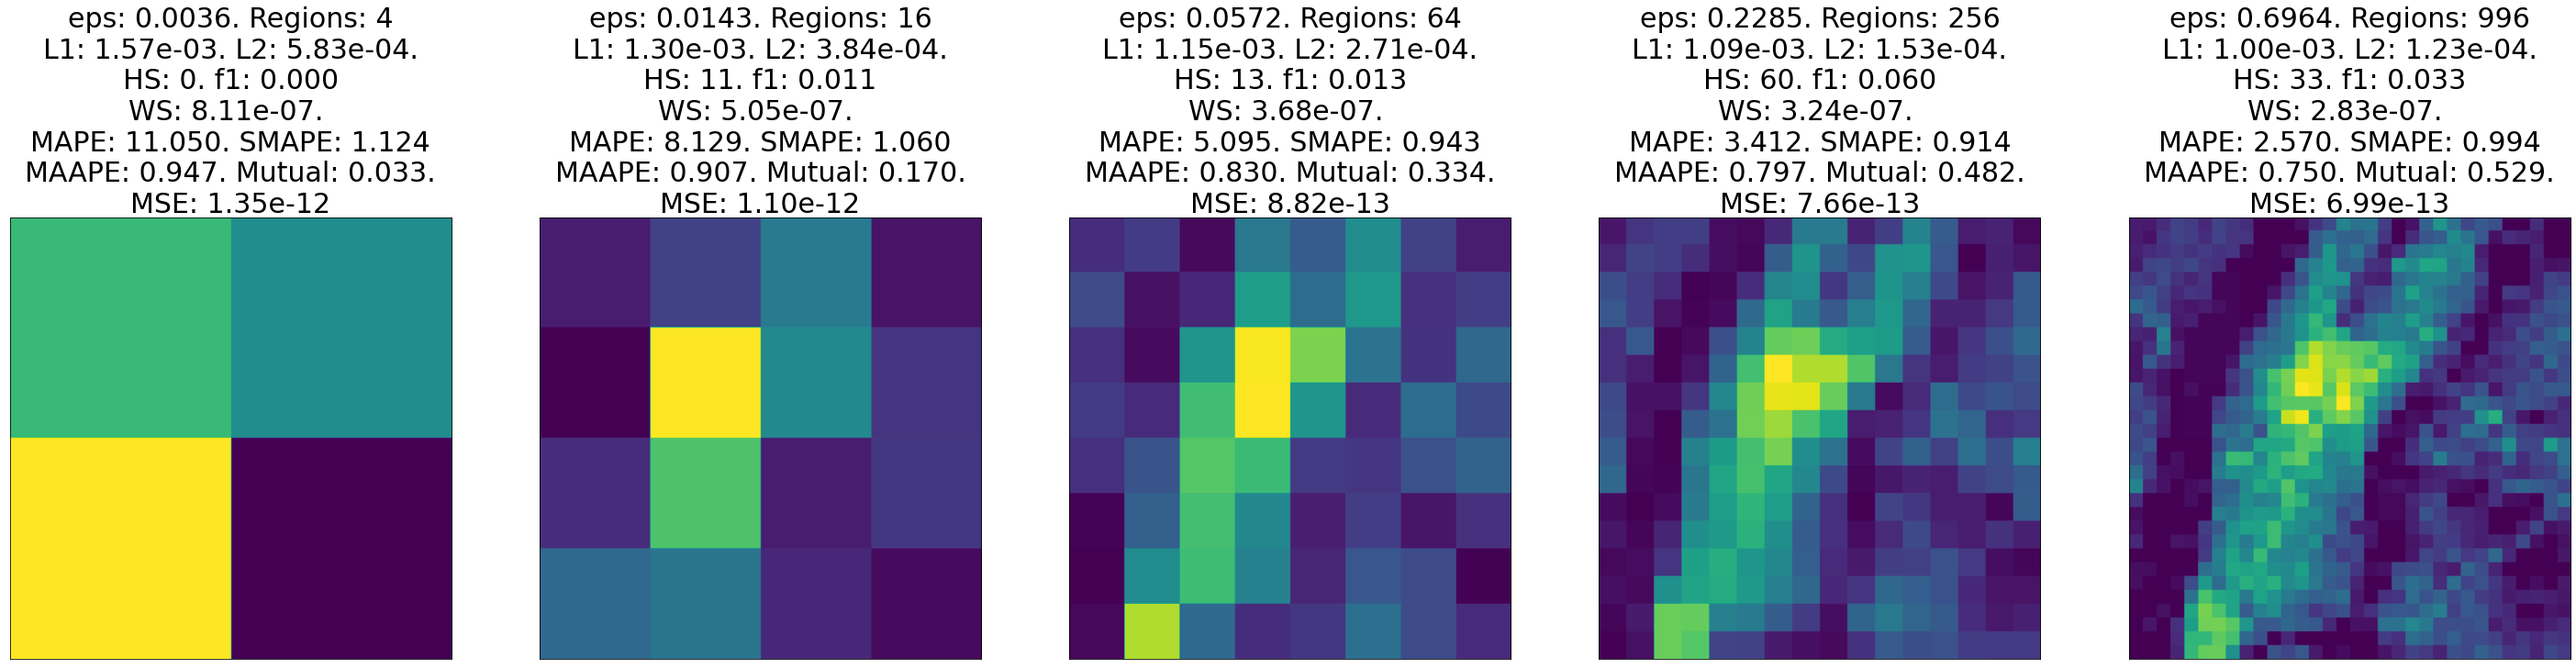

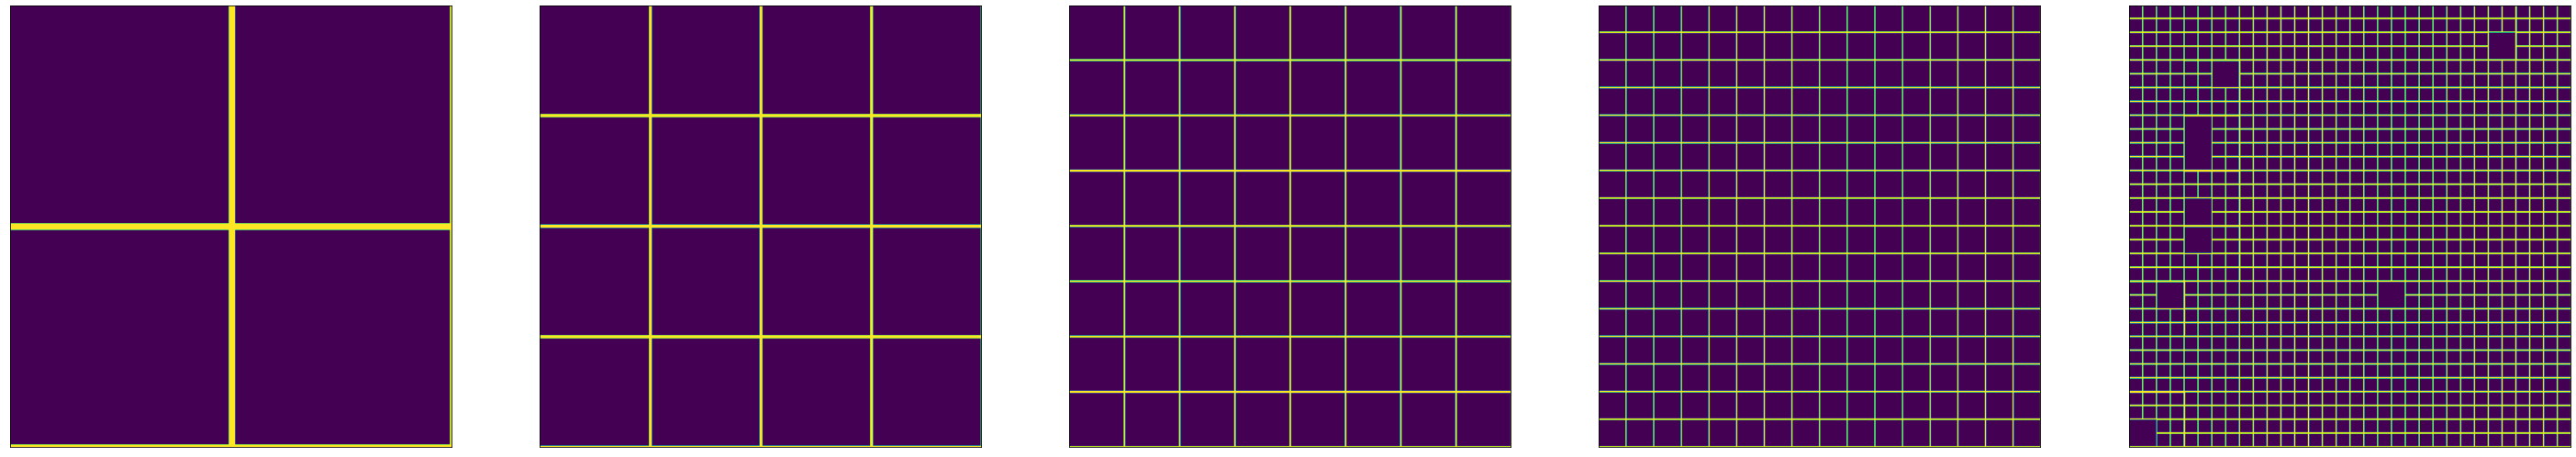

In [ ]:
users = 100000
secagg_size = 10000
c = 1/10
res100k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   min_dp_size=9000,
                   dropout_rate=0.1,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)


positivity: False
Total of 100.0 SecAgg rounds per level


  0%|          | 1090/1000000 [00:00<01:31, 10894.58it/s]

Level: 0. Eps: 0.0011313707895586728. Threshold: 10.00. Remaining: 1.00


Level: 0. MSE: 2.29e-12, without sampling error: 1.35e-12.


  0%|          | 1075/1000000 [00:00<01:32, 10746.30it/s]

Level: 1. Eps: 0.00452547953785703. Threshold: 10.00. Remaining: 1.00


Level: 1. MSE: 2.03e-12, without sampling error: 1.09e-12.


  0%|          | 801/1000000 [00:00<02:07, 7819.00it/s]

Level: 2. Eps: 0.018101686455752795. Threshold: 10.00. Remaining: 0.99


Level: 2. MSE: 1.82e-12, without sampling error: 8.82e-13.


  0%|          | 401/1000000 [00:00<04:15, 3907.33it/s]

Level: 3. Eps: 0.07239192600495825. Threshold: 10.00. Remaining: 0.98


Level: 3. MSE: 1.70e-12, without sampling error: 7.63e-13.


  0%|          | 101/1000000 [00:00<18:39, 892.90it/s]

Level: 4. Eps: 0.28526856439496157. Threshold: 10.00. Remaining: 0.90


Level: 4. MSE: 1.62e-12, without sampling error: 6.86e-13.


  0%|          | 0/1000000 [00:00<?, ?it/s]

Last round. Spending remaining epsilon budget: 618580.9728169116
Level: 5. Eps: 0.6185809728169116. Threshold: 10.00. Remaining: 0.62


Level: 5. MSE: 1.54e-12, without sampling error: 6.13e-13.
Total epsilon-users: 1000000.00 with 1.00 eps per person. 


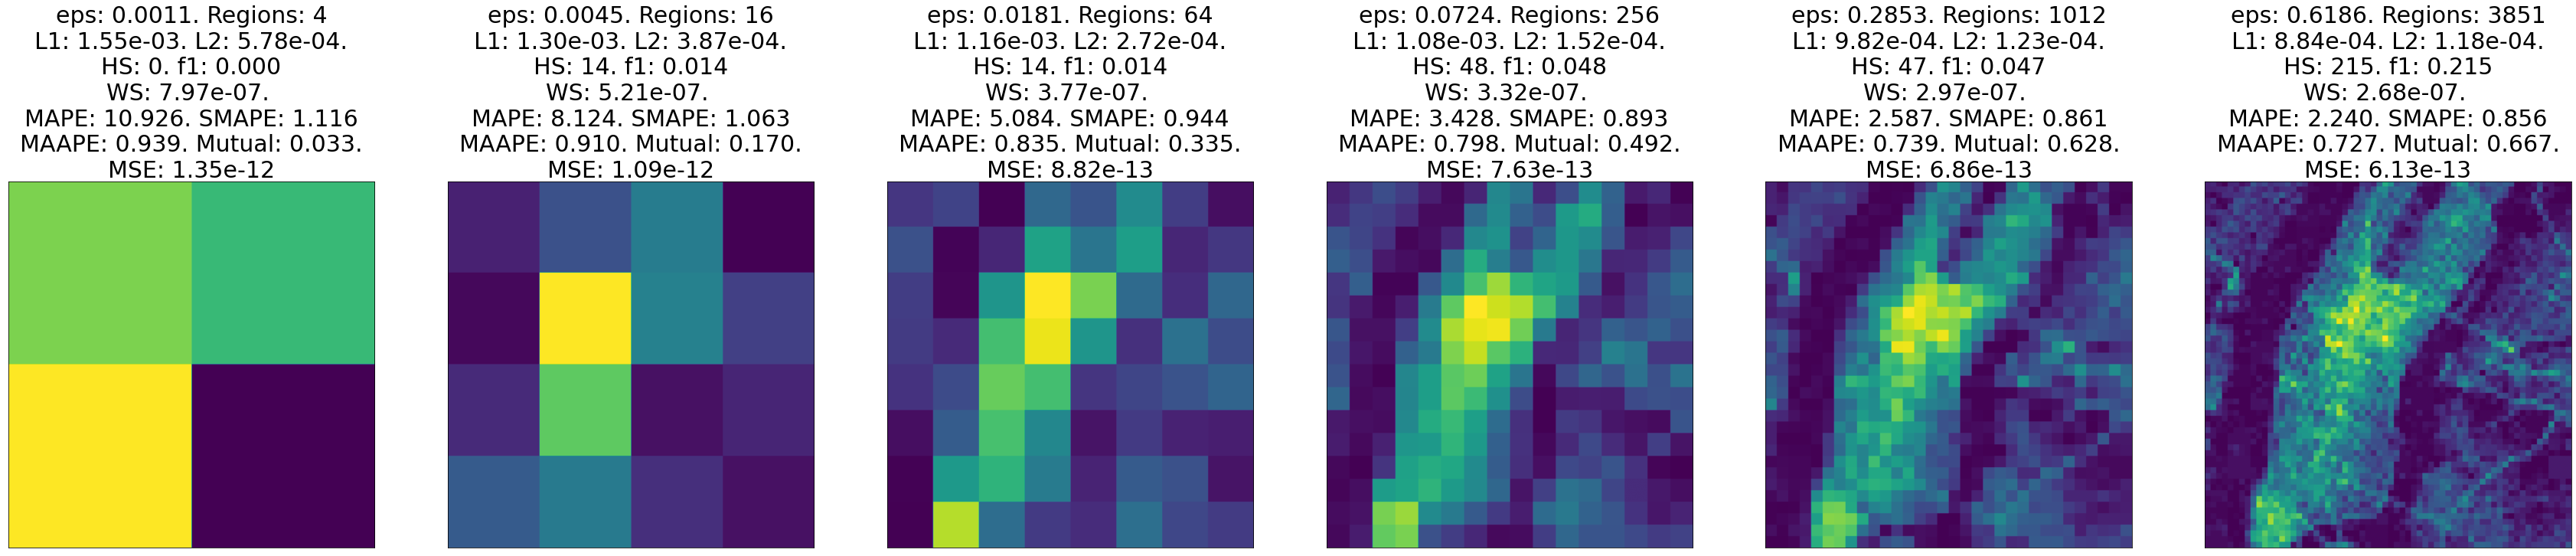

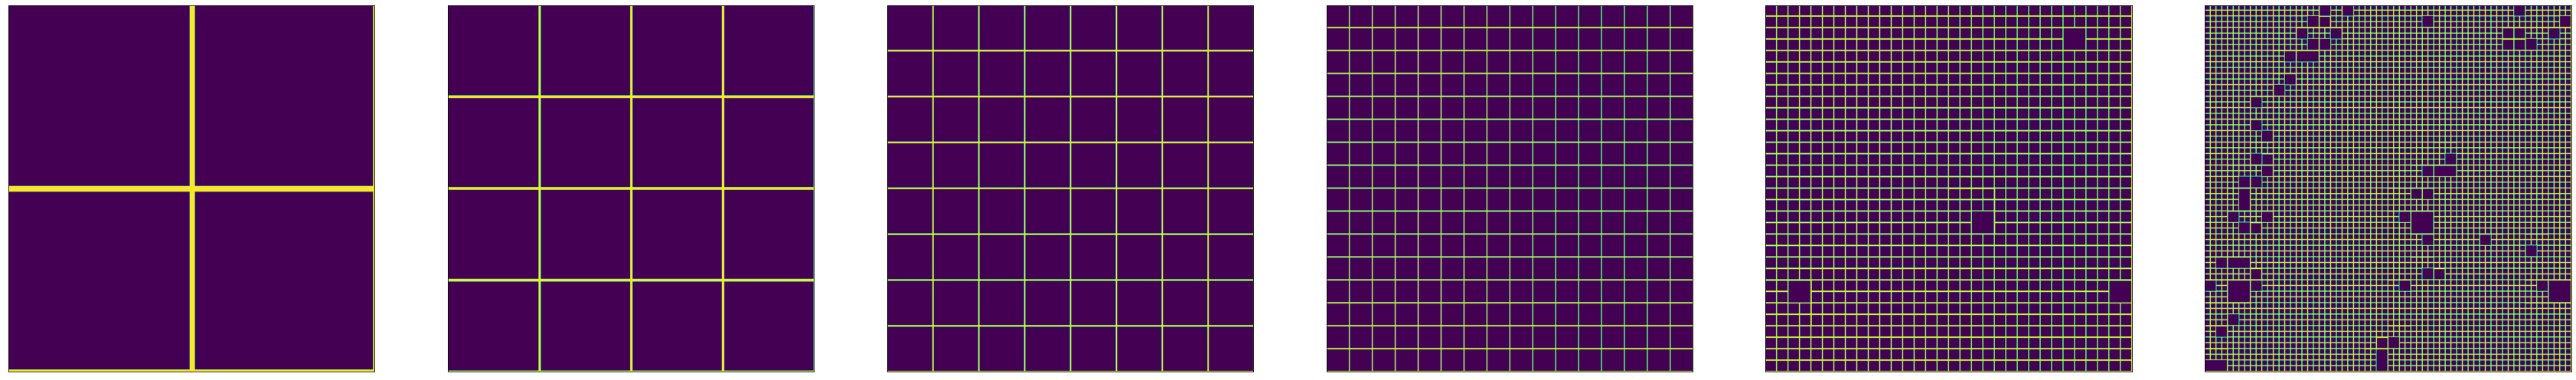

In [17]:
users = 1000000
secagg_size = 10000
c = 1/10
res1mln = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   min_dp_size=9000,
                   dropout_rate=0.1,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)


# Adding more data

In [ ]:
split_dataset = geo_utils.makeGaussian(true_image, 1024, 500, [200, 900], convert=True, save=True, load=False)


100%|██████████| 1024/1024 [00:17<00:00, 58.57it/s] 


Saved to split_dataset_500_200_900.pt


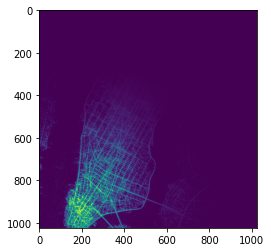

In [ ]:
plt.imshow(split_dataset['pos_image'])

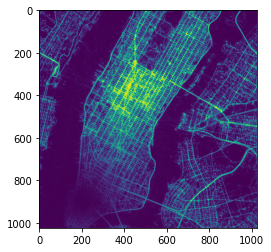

In [ ]:
plt.imshow(split_dataset['neg_image'])